## Profiling co-clustering modes

This Notebook compares the memory footprint and the performance of three different run modes for the co-clustering analysis in `cgc`. 

NOTE: This notebook makes use of [memory_profiler](https://github.com/pythonprofilers/memory_profiler), run the following block to install it using `pip`:

In [ ]:
!pip install memory-profiler

In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np 
import logging 
import sys 
import cgc

from memory_profiler import memory_usage

from cgc import coclustering_numpy

logging.basicConfig(level=logging.INFO, stream=sys.stdout, format="%(asctime)-15s %(levelname)-5s - %(message)s")

In [2]:
# Set up profiling functions
def plot(memory):
    """ Plot memory usage vs time """
    plt.plot(np.array(memory) - memory[0])
    plt.xlabel('Time step')
    plt.ylabel('Memory / MB')
    plt.show()
    
def profile(f, Z, input):
    # benchmark timing
    %timeit _ = f(Z, **input)
    # compute memory usage and plot it
    (memory, (conv, iters, r, c, e)) = memory_usage((f, (Z,), input), 
                                                    interval=0.01, 
                                                    retval=True)
    plot(memory)
    # print output
    print(r, c, e)

In [3]:
Z = np.random.randint(100, size=(500000, 50)).astype('float64') 
k = 250; l = 10
print('size of Z = {} MB'.format(Z.nbytes/2**20))

size of Z = 190.73486328125 MB


In [4]:
(m, n) = Z.shape
row_clusters = coclustering_numpy._initialize_clusters(m, k)
col_clusters = coclustering_numpy._initialize_clusters(n, l)

In [5]:
input = {'nclusters_row':k, 
         'nclusters_col':l, 
         'errobj':1.e-5, 
         'niters':5, 
         'epsilon':1.e-8,
         'row_clusters_init': row_clusters,
         'col_clusters_init': col_clusters,}

### Mode 1: normal run 
In this mode the memory requirement is high due to the usage of many large matrices. However the algorithm can rely on  fast matrix multiplications so the performance is also high.

15.8 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


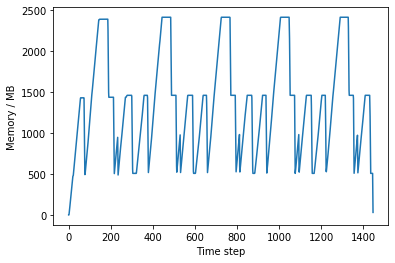

[ 35 136  12 ... 224 224 157] [1 4 0 0 9 8 5 5 7 5 2 5 7 6 2 8 3 2 4 0 3 9 4 7 4 1 2 0 8 4 7 9 6 1 9 5 9
 1 0 3 6 6 3 8 8 2 7 3 6 1] -3616922779.075045


In [6]:
input['low_memory'] = False
input['numba_jit'] = False
profile(coclustering_numpy.coclustering, Z, input)

### Mode 2: low-memory run
In this mode the memory usage is significantly reduced by replacing large matrix multiplications with for loops.
This comes at the cost of the performance.

27.1 s ± 587 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


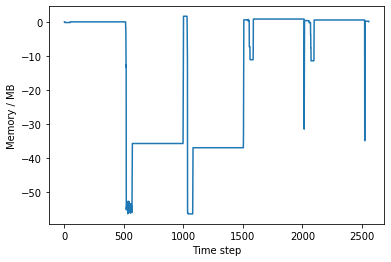

[ 35 136  12 ... 224 224 157] [1 4 0 0 9 8 5 5 7 5 2 5 7 6 2 8 3 2 4 0 3 9 4 7 4 1 2 0 8 4 7 9 6 1 9 5 9
 1 0 3 6 6 3 8 8 2 7 3 6 1] -3616922779.0750217


In [7]:
input['low_memory'] = True
input['numba_jit'] = False
profile(coclustering_numpy.coclustering, Z, input)

### Mode 3: low-memory run with numba acceleration
In this mode we still use the low memery configuration, but use [Numba](https://numba.pydata.org) to accelerate the for loops. The memory footprint is still low, and the performance is intermediate between the two previous cases.

23.2 s ± 495 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


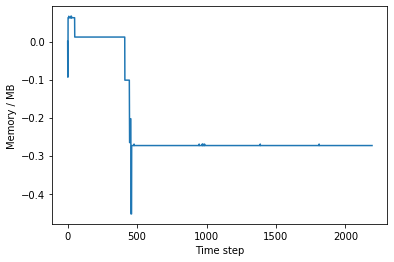

[ 35 136  12 ... 224 224 157] [1 4 0 0 9 8 5 5 7 5 2 5 7 6 2 8 3 2 4 0 3 9 4 7 4 1 2 0 8 4 7 9 6 1 9 5 9
 1 0 3 6 6 3 8 8 2 7 3 6 1] -3616922779.0750356


In [8]:
input['low_memory'] = True
input['numba_jit'] = True
profile(coclustering_numpy.coclustering, Z, input)